# Predicting Montly Milk Production with a RNN

This notebook will use a recurrent neural network (RNN) to predict monthly 
milk prodcution in pounds per cow.

The data can be found here:
https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load the data
milk = pd.read_csv('monthly-milk-production.csv',index_col='Month')
milk.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


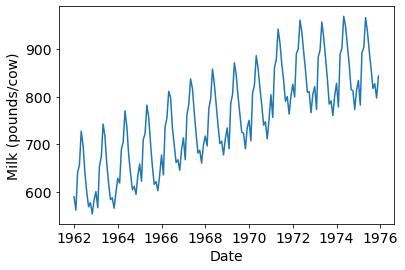

In [3]:
# Plot the data
milk.index = pd.to_datetime(milk.index)
plt.plot(milk.index,milk['Milk Production'])
plt.xlabel('Date')
plt.ylabel('Milk (pounds/cow)')
plt.show()

## Data Preprocessing

We will use the last 12 months of data as testing data and the rest will be training data

In [4]:
# Function for creating batches of training data
def next_batch(dataset,step_size):
    r''' Function to create random batches of training and 
    testing data from provided dataset.
    
    Parameters:
    -----------
    dataset: array
        1D array of time series data
    batch_size:
        number of batches to return
    step_size:
        number of time steps for each batch
    
    Returns:
    --------
    train_batch:
        1D array of data for training
    train_label:
        1D array of values to predict during training
    '''
    
    # Choose random starting day but avoid choosing values
    # where towards the end of the array where there are not enough steps
    # to create a full batch of size step_size
    day = np.random.randint(0,len(dataset)-step_size)
    
    # Get batch based on step size
    batch = np.array(dataset[day:day+step_size+1]).flatten()
    
    return batch[:step_size], batch[step_size]

In [5]:
# Perform train/test split
train = milk.head(len(milk)-12)
test  = milk.tail(12)

In [6]:
# Scale and fit data
scaler = MinMaxScaler()
train_scaled  = scaler.fit_transform(train)
test_scaled   = scaler.transform(test)

In [7]:
# Create batches of data to be fed to our model
time_steps = 12
x_train = []
y_train = []

batch_size = 4000
for i in range(batch_size):
    x_batch, y_batch = next_batch(train_scaled,time_steps)
    x_train.append(x_batch)
    y_train.append(y_batch)

x_train, y_train = np.array(x_train).reshape(-1,time_steps,1),np.array(y_train).reshape(-1,)
print(x_train.shape,y_train.shape)

(4000, 12, 1) (4000,)


## Create LSTM Model

We will create an LSTM model with multiple layers and then train our model

In [8]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(100,input_shape=(x_train.shape[1],x_train.shape[2]),
                               return_sequences=False,activation='relu'))
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.LSTM(100,activation='relu'))
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(0.01))

In [9]:
model.fit(x_train,y_train,epochs=400,batch_size=10,shuffle=False,verbose=0)

In [10]:
# Make predictions for the test data
# We do this by feedings batches of 12 time steps since our model will only predict
# one time step in the future and not 12
seeds = list(train_scaled[-time_steps:])

for i in range(12):
    batch = np.array(seeds[-time_steps:]).reshape(1,time_steps,1)
    pred = model.predict(batch,batch_size=1)
    seeds.append(pred.flatten())


In [11]:
# Inverse transform predictions to convert back to pounds/cow
predictions = scaler.inverse_transform(seeds)

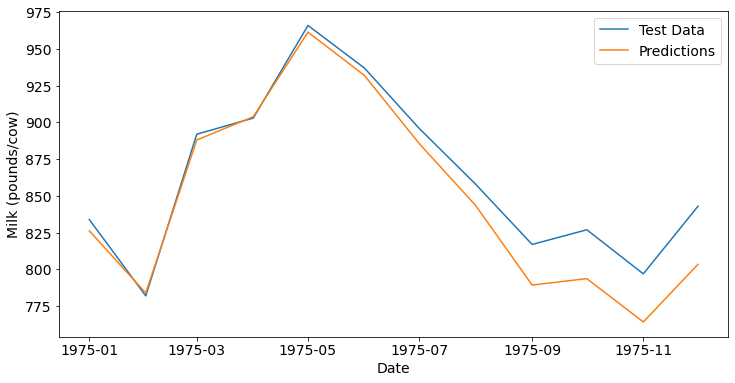

In [12]:
plt.figure(figsize=(12,6))
plt.plot(test,label='Test Data')
plt.plot(test.index,predictions[-12:],label='Predictions')
plt.xlabel('Date')
plt.ylabel('Milk (pounds/cow)')
plt.legend()
plt.show()